DBSCAN is another clustering algorithm that is quite favored in real production (e.g., speaking from experience, in https://vk.com/). The intuition behind the algorithm is related to finding an "approximation" for the centroid of the cluster. Instead of searching for one particular centroid, we'll find a set of "core points" that make up for the cluster's centroid.

#### When to use?
It is used in data with lots of noise present, so, in practice, it is applicable to any clustering problem.

#### Algorithm
- We define scalars $\epsilon$ and $\text{min\_samples}$, where the first one defines the distance that we find appropriate for two points to be related; the second one - minimum number of related points that one should have to become a "core point"
- Go around points, determening whether they are core points or not. After that we will have "approximate" centroids of distinct clusters
- Go around core points and assign the corresponding cluster's name to surrounding points based on whether they fall below some distance $\epsilon$
- All points that are left out of clusters now could be considered "noise"

In [59]:
import numpy as np

class DBSCAN():

    def __init__(self, eps=1, min_samples=6):
        self.eps = eps
        # subtracting one to count the centroid itself
        self.min_samples = min_samples-1 
        self.X = np.array([])
        self.visited_indices = []
        self.neighbors = {}
        self.clusters = []
        self.labels = []

    def _get_neighbors(self, index):
        """
        List of indices of neiboring points against X[index] 
        that fall within epsilon
        """
        nb = []
        for potential_nb_index in np.arange(0,self.X.shape[0])[
            np.arange(0,self.X.shape[0])!=index]:

            # if euclidean distance falls within epsilon
            if np.linalg.norm(self.X[potential_nb_index] \
                              - self.X[index]) < self.eps:
                nb.append(potential_nb_index)
        return nb
    
    def _expand_cluster(self, index, nbs):
        """ 
        Fill out clusters starting from approximate centroids
        and work the way up to borders via recursion
        """
        cluster = [index]
        for nb in nbs:
            if not nb in self.visited_indices:
                self.visited_indices.append(nb)
                
                # determine if the data point is part of the centroid
                # if it is, we are allowed to expand the cluster further
                # otherwise, we've reached the border
                self.neighbors[nb] = self._get_neighbors(nb)
                if len(self.neighbors[nb]) >= self.min_samples:
                    cluster += self._expand_cluster(nb,self.neighbors[nb])
                else:
                    cluster.append(nb)
        return cluster
    
    def _assign_cluster_labels(self):
        """
        Based on predicted clusters, return their labels
        """
        for label, cluster in enumerate(self.clusters):
            # each cluster is a list of indices
            self.labels[cluster] = label
        return self.labels
    
    def fit_predict(self, X):
        self.X = X
        
        # assume that before determining clusters every datapoint
        # is just noise
        self.labels = np.full((self.X.shape[0], ),-1)
        for index in range(self.X.shape[0]):
            if not index in self.visited_indices:
                self.neighbors[index] = self._get_neighbors(index)

                # if the point is a potential core point
                # otherwise we do not append it and treat it
                # as an unclustered, unknown data point
                if len(self.neighbors[index]) >= self.min_samples:
                    self.visited_indices.append(index)
                    self.clusters.append(
                        self._expand_cluster(index, self.neighbors[index])
                    )
        return self._assign_cluster_labels()

Now we can compare our custom implementation with scikit-learn on their own example $X$ provided in DBSCAN docs:

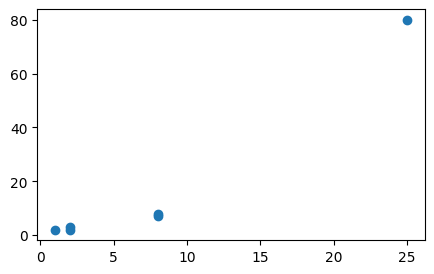

In [70]:
import matplotlib.pyplot as plt

X = np.array([[1, 2], [2, 2], [2, 3],
            [8, 7], [8, 8], [25, 80]])
plt.scatter(X[:,0],X[:,1])
plt.rcParams["figure.figsize"] = (5,3)

In [73]:
# custom implementation
DBSCAN(eps=3,min_samples=2).fit_predict(X)

array([ 0,  0,  0,  1,  1, -1])

In [71]:
# sklearn implementation
from sklearn.cluster import DBSCAN as DBSCAN_sklearn
DBSCAN_sklearn(eps=3, min_samples=2).fit_predict(X)

array([ 0,  0,  0,  1,  1, -1], dtype=int64)